In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
import fastai
from fastai.imports import *

from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/apps/software/standard/core/anaconda3/5.2.0/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = "/scratch/kk4ze/data_lowres_1100x1100_augmented/"
sz=1100

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
os.listdir(PATH)

['models', 'tmp', 'valid', '.ipynb_checkpoints', 'train']

In [7]:
files = os.listdir(f'{PATH}valid/Celiac')[:5]
files

['C07-37_06_8055_8580_vert__0.jpg',
 'C04-19_03_10858_6377_horiz__1.jpg',
 'C17-80_01_14732_17747_vert__0.jpg',
 'C06-33_02_8189_5011_horiz__0.jpg',
 'C06-30_04_9949_8871_horiz__0.jpg']

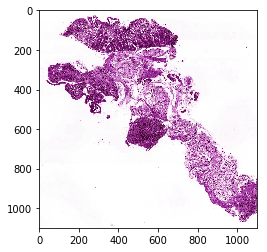

In [8]:
img = plt.imread(f'{PATH}valid/Celiac/{files[4]}')
plt.imshow(img);

In [10]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz),bs=8)


In [11]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [12]:
learn.fit(0.001, 8)

epoch      trn_loss   val_loss   accuracy                   
    0      1.014567   0.655108   0.734104  
    1      0.734059   0.539323   0.815029                   
    2      0.642421   0.519831   0.797688                   
    3      0.610337   0.503164   0.797688                   
    4      0.55261    0.483842   0.809249                   
    5      0.503059   0.483662   0.809249                   
    6      0.461725   0.468896   0.797688                   
    7      0.412788   0.487666   0.803468                   


[0.4876661094368538, 0.8034682080924855]

## Visualising Results

In [12]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2])

In [13]:
# from here we know that 'Celiac' is label 0 and 'EE' is label 1 and 'Normal' is label 2
data.classes

['Celiac', 'EE', 'Normal']

In [14]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(173, 3)

Most Correct Celiac


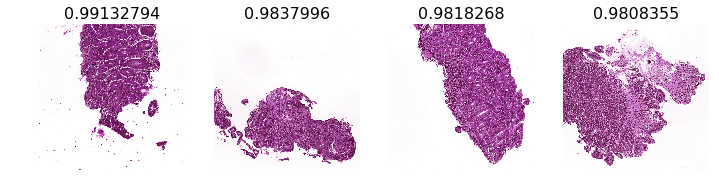

In [15]:
imr = ImageModelResults(data.val_ds, log_preds)
print('Most Correct Celiac')
imr.plot_most_correct(0)

Most Correct EE


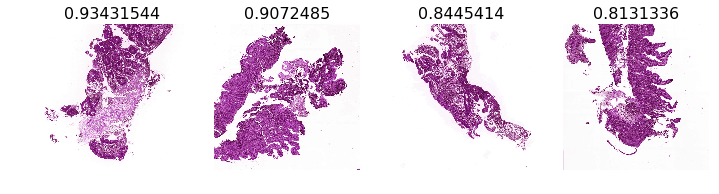

In [16]:
print('Most Correct EE')
imr.plot_most_correct(1)

Most Correct Normal


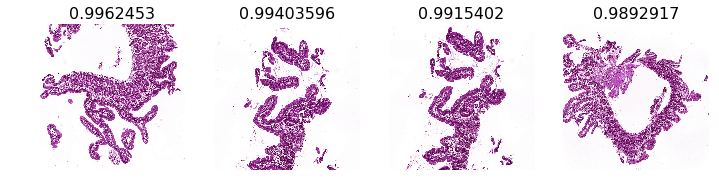

In [17]:
print('Most Correct Normal')
imr.plot_most_correct(2)

Most Incorrect Celiac


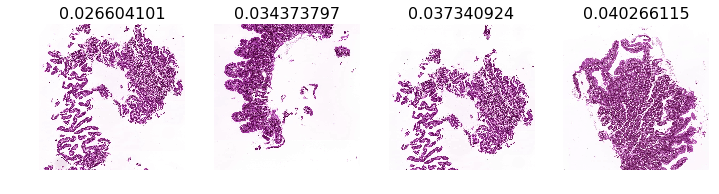

In [18]:
print('Most Incorrect Celiac')
imr.plot_most_incorrect(0)

Most Incorrect EE


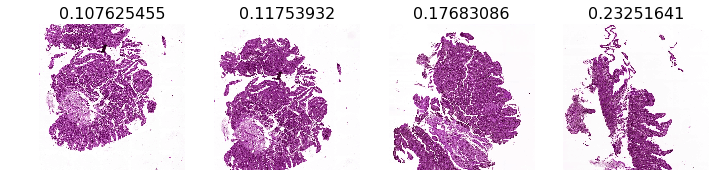

In [19]:
print('Most Incorrect EE')
imr.plot_most_incorrect(1)

Most Incorrect Normal


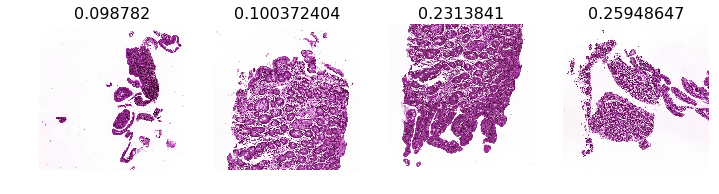

In [20]:
print('Most Incorrect Normal')
imr.plot_most_incorrect(2)

In [21]:
preds = np.argmax(log_preds, axis=1)

In [22]:
y = data.val_y

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[63  5 15]
 [ 4  8  2]
 [ 9  3 64]]


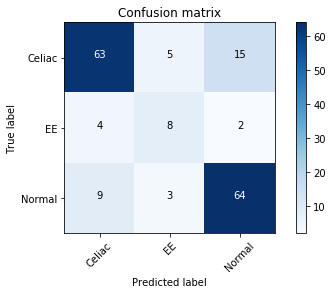

In [24]:
plot_confusion_matrix(cm, data.classes)

## Finding a optimum learning rate

In [25]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [26]:
lrf=learn.lr_find()

 84%|████████▎ | 41/49 [00:00<00:00, 167.27it/s, loss=1.89]


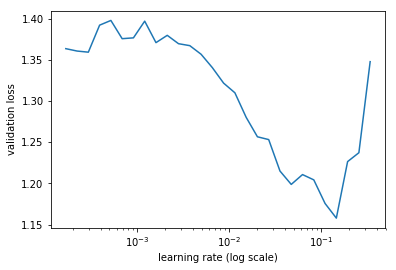

In [27]:
learn.sched.plot()

## Data Augmentation

In [28]:
# Using predefined augmentations transforms_top_down
tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

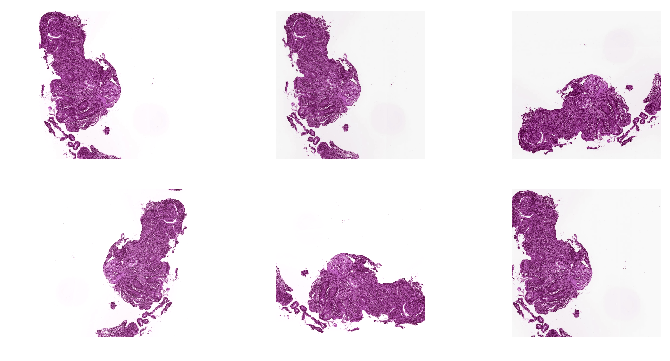

In [29]:
# Visualising the augmentation
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [30]:
# Initializing the data with augmentation and learn method
data = ImageClassifierData.from_paths(PATH, tfms=tfms,bs=16)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.precompute = False

In [31]:
lrf=learn.lr_find()

 88%|████████▊ | 43/49 [00:30<00:03,  1.61it/s, loss=4.85]

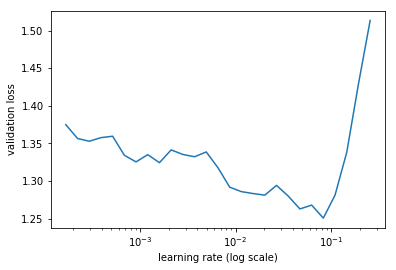

In [32]:
learn.sched.plot()

In [33]:
learn.fit(0.03, 10, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      1.138813   0.792612   0.705202  
    1      1.115938   0.730234   0.710983                  
    2      1.055959   0.975774   0.734104                  
    3      1.106728   0.945415   0.739884                  
    4      1.495571   1.235506   0.751445                  
    5      1.255058   1.191676   0.734104                  
    6      1.081348   0.898771   0.763006                  
    7      0.810339   0.632005   0.763006                  
    8      0.716783   0.608194   0.751445                  
    9      0.673822   0.589002   0.774566                  


[0.5890021596340774, 0.7745664788119365]

In [ ]:
learn.save('1100_lastlayer_resnet34_lowres_staintools')

In [ ]:
learn.load('1100_lastlayer_resnet34_lowres_staintools')

## Unfreezing layers and using Differential learning rates

In [13]:
# Unfreeze all layers for training
learn.unfreeze()

In [14]:
lrf=learn.lr_find()

 75%|███████▌  | 73/97 [00:22<00:07,  3.41it/s, loss=1.5]  

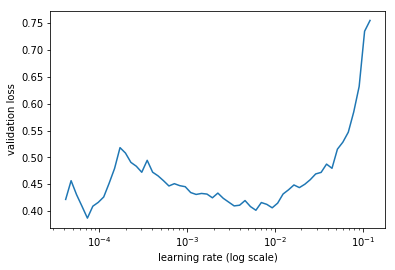

In [15]:
learn.sched.plot()

In [16]:
lr = (1e-2 + 1e-3)/2

In [17]:
lr=np.array([lr/9,lr/3,lr])

In [18]:
learn.fit(lr, 6, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.540021   0.493189   0.786127  
    1      0.472922   0.594914   0.780347                  
    2      0.409049   0.576642   0.774566                  
    3      0.51598    0.607458   0.791908                  
    4      0.449871   0.613397   0.786127                  
    5      0.371952   0.575714   0.768786                  
    6      0.397315   0.59228    0.786127                  
    7      0.408956   0.548224   0.786127                  
    8      0.427445   0.59628    0.791908                  
    9      0.37908    0.60696    0.803468                  
    10     0.35904    0.581896   0.803468                  
    11     0.410783   0.579692   0.780347                  
    12     0.247341   0.531451   0.803468                  
    13     0.278538   0.506472   0.803468                  
    14     0.295149   0.533915   0.815029                  
    15     0.309231   0.53981    0.820809               

KeyboardInterrupt: 

In [ ]:
learn.save('1100_lowres_resnet34_staintools')

In [ ]:
learn.load('1100_lowres_resnet34_staintools')

## Analyzing results

### Confusion Matrix and Accuracy with Test Time Augmentation

In [ ]:
# Getting log predictions with TTA
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

In [ ]:
log_preds.shape

In [ ]:
np.save('/scratch/kk4ze/data_lowres_augmented/logpreds_resnet50_all_layers256x256_duplicates_TTA_staintools.npy', log_preds)

In [ ]:
log_preds = np.load('/scratch/kk4ze/data_lowres_augmented/logpreds_resnet50_all_layers256x256_duplicates_TTA_staintools.npy')

In [ ]:
log_preds_mean = np.mean(log_preds, 0)

In [ ]:
preds = np.argmax(probs, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

### Visualizing results with TTA

In [ ]:
imr = ImageModelResults(data.val_ds, log_preds_mean)
print('Most Correct Celiac')
imr.plot_most_correct(0)

In [ ]:
print('Most Correct EE')
imr.plot_most_correct(1)

In [ ]:
print('Most Correct Noraml')
imr.plot_most_correct(2)

In [ ]:
print('Most Incorrect Celiac')
imr.plot_most_incorrect(0)

In [ ]:
print('Most Incorrect EE')
imr.plot_most_incorrect(1)

In [ ]:
print('Most Incorrect Normal')
imr.plot_most_incorrect(2)

In [ ]:
print('Most Uncertain Celiac')
imr.plot_most_uncertain(0)

In [ ]:
print('Most Uncertain EE')
imr.plot_most_uncertain(1)

In [ ]:
print('Most Uncertain Normal')
imr.plot_most_uncertain(2)

### Confusion Matrix and Accuracy without Test Time Augmentation

In [ ]:
# Getting log predictions without TTA
log_preds = learn.predict()

In [ ]:
preds = np.argmax(log_preds, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

## Saving predictions of the model with TTA

In [ ]:
np.exp(log_preds_mean)

In [ ]:
res = pd.DataFrame(np.exp(log_preds_mean))

In [ ]:
res['file'] = data.val_ds.fnames

In [ ]:
res.columns = ['Celiac', 'EE', 'Normal', 'FileName']

In [ ]:
res.to_csv('../results/preds_resnet50_256_duplicates_TTA_staintools.csv')

In [ ]:
res.head()